In [16]:
pip install -r /teamspace/studios/this_studio/Main/dataset/TruthSeeker2023/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np

# Charger le dataset
df = pd.read_csv(r"/teamspace/studios/this_studio/final_dataset.csv")

# Supprimer les lignes où la colonne "label" est NaN ou inf
df = df[~df["label"].isna()]  # enlève les NaN
df = df[~df["label"].isin([np.inf, -np.inf])]  # enlève les infinis

# Ensuite tu peux convertir en entier
df["label"] = df["label"].astype(int)


In [18]:
from sklearn.model_selection import train_test_split

# Split train / test
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['label']
)

In [19]:
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

In [20]:
from transformers import BertTokenizer

# Initialiser le tokenizer de BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [21]:
#Tokenization
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

In [22]:
import torch
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

In [23]:
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

# Fine-Tuning de BERT


In [24]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from datasets import Dataset

#### Chargement du modéle BERT avec QLoRA (4-bit)

In [25]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    quantization_config=bnb_config,
    device_map="auto"
)

model = prepare_model_for_kbit_training(base_model)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 2,680,322 || all params: 112,164,100 || trainable%: 2.3896


In [27]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [28]:
# Add this check before creating the Trainer
if val_dataset is None:
    print("ERROR: val_dataset is None")
elif len(val_dataset) == 0:
    print("ERROR: val_dataset is empty")
else:
    print(f"val_dataset has {len(val_dataset)} samples")

val_dataset has 14896 samples


In [29]:
# pour stocker les scores dans un fichier
from transformers import TrainerCallback
import json

class SaveMetricsCallback(TrainerCallback):
    def __init__(self, path="metrics_log.json"):
        self.path = path
        self.metrics = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is not None:
            self.metrics.append({"epoch": state.epoch, "step": state.global_step, **metrics})
            with open(self.path, "w") as f:
                json.dump(self.metrics, f, indent=2)


In [30]:
training_args = TrainingArguments(
    output_dir="./results-qlora",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none",
    learning_rate=2e-4,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback()]
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [32]:
trainer.train()

/tmp/ipykernel_3263/3397341743.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(val[idx])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.157500,0.121200,0.948778,0.963199,0.960928,0.965481
2,0.111000,0.118974,0.952403,0.966023,0.957625,0.974570
3,0.083800,0.141292,0.954484,0.967727,0.953028,0.982885
4,0.059500,0.181156,0.951866,0.965577,0.958901,0.972346


/tmp/ipykernel_3263/3397341743.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(val[idx])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/tmp/ipykernel_3263/3397341743.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ke

TrainOutput(global_step=14896, training_loss=0.10293796776956954, metrics={'train_runtime': 6830.6505, 'train_samples_per_second': 34.892, 'train_steps_per_second': 2.181, 'total_flos': 1.6167549405745152e+16, 'train_loss': 0.10293796776956954, 'epoch': 4.0})

"Nous avons évalué les performances du modèle à chaque époque. Le score F1 converge dès la 4e époque, ce qui justifie le choix d’un nombre d’époques réduit pour éviter l’overfitting."

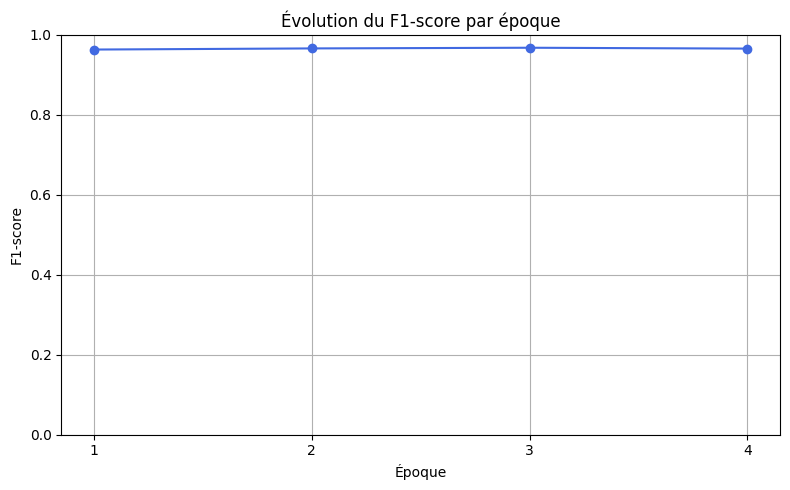

In [2]:
import json
import matplotlib.pyplot as plt

# Charger les métriques
with open("/teamspace/studios/this_studio/metrics_log.json", "r") as f:
    metrics = json.load(f)

# Extraire les données
epochs = [m["epoch"] for m in metrics]
f1_scores = [m["eval_f1"] for m in metrics]

# Tracer la courbe
plt.figure(figsize=(8, 5))
plt.plot(epochs, f1_scores, marker="o", color="royalblue")
plt.title("Évolution du F1-score par époque")
plt.xlabel("Époque")
plt.ylabel("F1-score")
plt.grid(True)
plt.xticks(epochs)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("courbe_f1.png")
plt.show()
